In [26]:
import numpy as np
import matplotlib.pyplot as plt
from spec_id import Gen_spec, Median_w_Error_cont,Median_w_Error, Gen_spec, Oldest_galaxy
import seaborn as sea
import pandas as pd
from glob import glob
from astropy.io import fits
from astropy.table import Table
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
%matplotlib inline

In [27]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126 and ids != 48631')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')

metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [28]:
vjDB = pd.read_pickle('../data/uvj_db.pkl')
uvjSDB = pd.read_pickle('../data/select_samp.pkl')

In [34]:
uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in']

49     1.439123
50     1.155792
58     1.399638
61     1.231870
62     1.070560
69     1.266528
86     1.070375
96     1.224270
107    1.088137
212    1.111450
217    1.275546
219    1.387961
220    1.224143
221    1.206243
223    1.165100
224    1.218216
225    1.286771
227    1.162904
228    1.031936
230    1.138784
231    1.241626
232    1.318571
234    1.240715
235    1.177448
236    0.987749
246    1.368332
248    1.122150
251    1.263642
258    1.169351
259    1.175290
260    1.082841
267    1.158114
Name: (V-J), dtype: float64

In [ ]:
uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in'], galDB.indx

In [36]:
casey_DB = pd.DataFrame({'gids':galDB.gids,'(U-V)':uvjSDB['(U-V)'][uvjSDB.IN_SAMP == 'in'],'(V-J)':uvjSDB['(V-J)'][uvjSDB.IN_SAMP == 'in'],
              'lmass':galDB.rf_lmass,'z_grism':galDB.hi_res_specz,'age':galDB.tx_lwa})

In [37]:
casey_DB.to_csv('../data/uvj_age_DB.txt',sep=' ')

In [3]:
print len(lzDB)
print len(mzDB)
print len(hzDB)
print len(uhzDB)

11
8
6
7


WFC3/IR coverage : 136" X 123"

Area: 16728 arcsec$^2$

$dV_c = D_H \frac{(1+z)^2 D^2_A}{E(z)} d\Omega \: dz$

$D_H = \frac{c}{H_0} $

$H_0 = 100 \; h  \; km \; s^{-1} Mpc^{-1} $

$D_A = \frac{D_M}{1+z} $

$E(z) = \sqrt{\Omega_M (1+z)^3 + \Omega_k (1+z)^2 + \Omega_\Lambda}$

$D_M = D_C$

$D_C = D_H \int_0^z \frac{dz'}{E(z')}$

$\Omega_M = 0.3$

$\Omega_\Lambda = 0.7$

$h = 0.7$

$radians = 206265"$

$side A = 6.59 X 10^{-4} \: rad$

$side B = 5.96 X 10^{-4} \: rad$

Total solid angle = $3.928 X 10^{-7} \: sterad$

In [4]:
136*123

16728

In [5]:
136 / 206265.

0.0006593459869585242

In [6]:
6.59E-4 * 5.96E-4

3.92764e-07

In [3]:
def D_H(h):
    return 3E5 /(100*h)

def E_z(Om,Ok,Ol,z):
    return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)

def D_c(Om,Ok,Ol,z,h):
    z_range = np.linspace(0,z,100)
    
    x = np.zeros(100)
    for i in range(len(x)):
        x[i] = E_z(Om,Ok,Ol,z_range[i])
    
    return D_H(h)*np.trapz(1/x, z_range)

def D_A(Om,Ok,Ol,z,h):
    return D_c(Om,Ok,Ol,z,h) / (1+z)

def V_c(Om,Ok,Ol,z,h,sA):
    #sA = solid angle
    z_range = np.linspace(0,z,100)
    
    x = np.zeros(100)
    for i in range(len(x)):
        x[i] = ((1+z_range[i])**2 * D_A(Om,Ok,Ol,z_range[i],h)**2) / E_z(Om,Ok,Ol,z_range[i])

    return D_H(h) * sA * np.trapz(x,z_range)

In [9]:
16 / (12 * (V_c(0.3,0,0.7,1.8,0.7,3.928E-7) - V_c(0.3,0,0.7,1,0.7,3.928E-7)))

0.00012710605824483402

In [25]:
6 / (12 * (V_c(0.3,0,0.7,1.8,0.7,3.928E-7) - V_c(0.3,0,0.7,1.4,0.7,3.928E-7)))

8.8068848605177161e-05

In [16]:
(12 * (V_c(0.3,0,0.7,1.8,0.7,3.928E-7) - V_c(0.3,0,0.7,1,0.7,3.928E-7)))

125879.1297672099

In [17]:
(12 * (V_c(0.3,0,0.7,1.8,0.7,1) - V_c(0.3,0,0.7,1,0.7,1)))

320466216311.63409

In [19]:
V_c(0.3,0,0.7,1,0.7,4*np.pi)/1E9

151.37374566898401

In [8]:
galDB[galDB.lmass >
      10.85]

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,t_+_sig_cal,tx_cal,tx_-_sig_cal,tx_+_sig_cal,Zx_cal,Zx_-_sig_cal,Zx_+_sig_cal,Z_cal,Z_-_sig_cal,Z_+_sig_cal
50,n17070,17070,189.268086,62.226445,1.192,10.92,8.48,0.011,0.003,0.004,...,0.516,2.043086,0.518036,0.573146,0.011427,0.002918,0.006565,0.012,0.003,0.006
61,n21156,21156,189.239409,62.247548,1.251,11.16,8.30,0.020,0.005,0.004,...,0.307,2.098196,0.418838,0.308617,0.023884,0.003928,0.003984,0.024,0.004,0.004
96,n34694,34694,189.147840,62.323647,1.145,10.94,8.30,0.015,0.006,0.005,...,0.963,2.803607,0.462926,0.958918,0.014345,0.004882,0.005667,0.015,0.006,0.005
107,n37686,37686,189.274474,62.360820,1.258,10.89,8.48,0.016,0.003,0.004,...,0.751,3.068136,0.473948,0.782565,0.014681,0.003928,0.005667,0.015,0.004,0.005
212,s35774,35774,53.158775,-27.742385,1.223,10.86,8.90,0.008,0.003,0.003,...,0.378,2.803607,0.859719,0.473948,0.008397,0.004433,0.009876,0.009,0.005,0.009
217,s38785,38785,53.168249,-27.727300,1.175,10.88,8.60,0.019,0.007,0.006,...,0.108,2.054108,0.242485,0.154309,0.026914,0.004377,0.002301,0.027,0.004,0.002
219,s39012,39012,53.064240,-27.727621,1.632,11.09,8.78,0.019,0.011,0.008,...,0.364,1.877756,0.374749,0.385772,0.021359,0.011222,0.006453,0.022,0.012,0.006
220,s39170,39170,53.041826,-27.725868,1.022,11.09,8.48,0.023,0.005,0.004,...,0.195,2.219439,1.025050,0.275551,0.028766,0.001964,0.000954,0.029,0.002,0.001
221,s39241,39241,53.042327,-27.726209,1.019,10.87,8.30,0.022,0.003,0.004,...,0.424,2.506012,0.529058,0.518036,0.023603,0.006397,0.004601,0.024,0.007,0.004
224,s39804,39804,53.178423,-27.724640,1.333,10.91,8.48,0.018,0.004,0.006,...,0.740,3.057114,0.562124,0.782565,0.013279,0.005331,0.009539,0.014,0.006,0.009


In [26]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')


In [27]:
galDB.ids[270]

48631

In [29]:
spec =  Gen_spec(galDB.gids[270],galDB.hi_res_specz[270])

No TEAL-based tasks available for this package!
../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


In [30]:
spec.Median_spec(galDB.Z_lwa[270],galDB.t_lwa[270],tau)

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


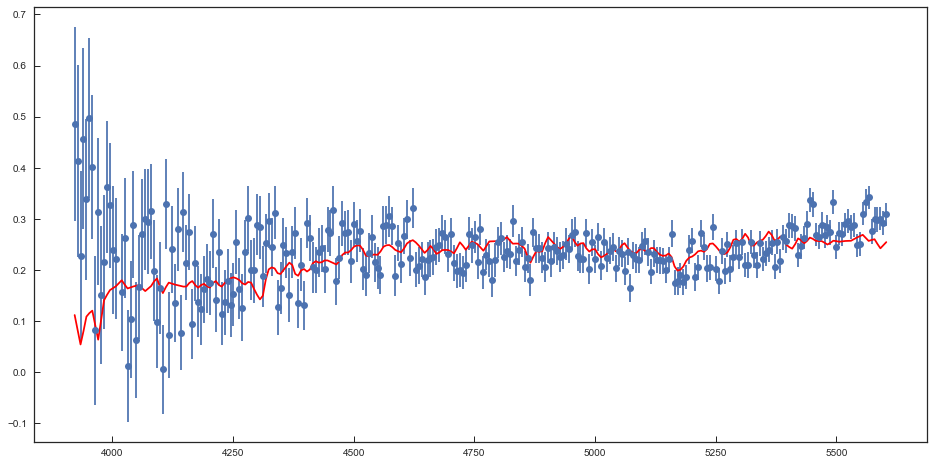

In [32]:
plt.figure(figsize=[16,8])
plt.errorbar(spec.gal_wv_rf, spec.gal_fl, spec.gal_er, fmt='o')
plt.plot(spec.gal_wv_rf, spec.fl,'r')

In [33]:
print galDB.Z_lwa[270]/0.019,galDB.t_lwa[270]

1.42105263158 4.7


In [30]:
Z,PZ = np.load('../chidat/s48631_dtau_Z_pos_lwa_3.npy')
t,Pt = np.load('../chidat/s48631_dtau_t_pos_lwa_3.npy')

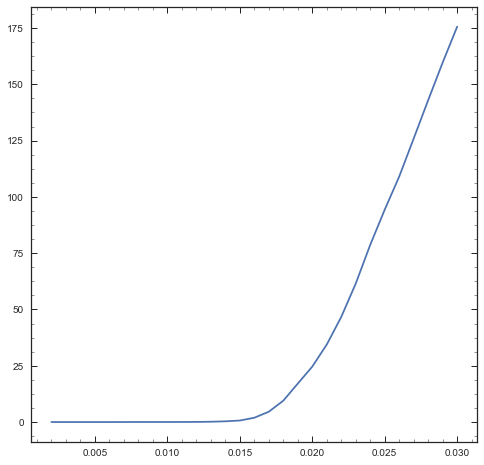

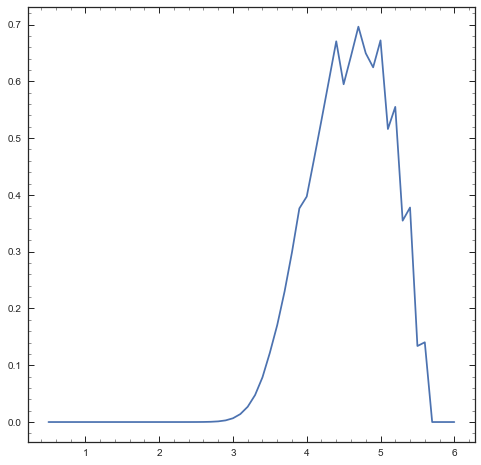

In [31]:
plt.figure(figsize=[8,8])

plt.plot(Z,PZ)

plt.figure(figsize=[8,8])
plt.plot(t,Pt)

In [21]:
uhzDB

,gids,ids,ra,dec,hi_res_specz,lmass,tau,Z_f,Z_-_sig_f,Z_+_sig_f,...,t_+_sig_cal,tx_cal,tx_-_sig_cal,tx_+_sig_cal,Zx_cal,Zx_-_sig_cal,Zx_+_sig_cal,Z_cal,Z_-_sig_cal,Z_+_sig_cal
62,n21427,21427,189.368121,62.247344,1.514,10.73,8.48,0.019,0.010,0.007,...,0.514,2.329659,0.584168,0.584168,0.017543,0.008810,0.008529,0.018,0.009,0.008
219,s39012,39012,53.064240,-27.727621,1.632,11.09,8.78,0.019,0.011,0.008,...,0.364,1.877756,0.374749,0.385772,0.021359,0.011222,0.006453,0.022,0.012,0.006
227,s40223,40223,53.124956,-27.722957,1.595,10.66,8.60,0.018,0.009,0.008,...,0.219,1.976954,0.297595,0.242485,0.022144,0.009034,0.005611,0.023,0.010,0.005
234,s41148,41148,53.127925,-27.718885,1.758,11.08,8.00,0.029,0.004,0.001,...,0.628,1.822645,0.407816,0.705411,0.027082,0.007743,0.002188,0.028,0.009,0.001
235,s41520,41520,53.152726,-27.716251,1.603,10.92,0.00,0.026,0.010,0.003,...,0.641,1.547094,0.286573,0.694389,0.016196,0.006733,0.008922,0.017,0.008,0.008
236,s41659,41659,53.096114,-27.716302,1.620,10.30,8.90,0.018,0.010,0.008,...,0.510,1.480962,0.429860,0.529058,0.018160,0.009427,0.008305,0.019,0.010,0.007
248,s44042,44042,53.104570,-27.705421,1.611,11.02,8.70,0.028,0.006,0.001,...,0.130,2.208417,0.143287,0.121242,0.027643,0.003198,0.001739,0.028,0.004,0.001


In [35]:
10**10.6 / 0.7

56872452936.21385

In [36]:
np.log10(10**10.6 / 0.7)

10.754901959985743

In [47]:
Oldest_galaxy(.7)

7.3105512706317874

In [46]:
Oldest_galaxy(3)

2.1489219706001306

In [5]:
south = Table.read('/Users/Vince.ec/FAST_v1.0/mini_catalogs/products/south.fout', format='ascii').to_pandas()
north = Table.read('/Users/Vince.ec/FAST_v1.0/mini_catalogs/products/north.fout', format='ascii').to_pandas()

In [11]:
print np.array([south.col1,south.col17]).T

[[  3.57740000e+04   1.08600000e+01]
 [  3.87850000e+04   1.08200000e+01]
 [  3.90120000e+04   1.11000000e+01]
 [  3.91700000e+04   1.10900000e+01]
 [  3.92410000e+04   1.08700000e+01]
 [  3.96310000e+04   1.06700000e+01]
 [  3.98040000e+04   1.09300000e+01]
 [  3.98050000e+04   1.04600000e+01]
 [  4.02230000e+04   1.06600000e+01]
 [  4.04760000e+04   1.06000000e+01]
 [  4.05970000e+04   1.09900000e+01]
 [  4.06230000e+04   1.07000000e+01]
 [  4.08620000e+04   1.09400000e+01]
 [  4.11480000e+04   1.11100000e+01]
 [  4.15200000e+04   1.09300000e+01]
 [  4.16590000e+04   1.02900000e+01]
 [  4.36150000e+04   1.06800000e+01]
 [  4.40420000e+04   1.10100000e+01]
 [  4.46200000e+04   1.05100000e+01]
 [  4.59720000e+04   1.08600000e+01]
 [  4.60660000e+04   1.09500000e+01]
 [  4.63450000e+04   1.01600000e+01]
 [  4.76770000e+04   1.01700000e+01]
 [  4.86310000e+04   1.09200000e+01]]


In [22]:
n_lmass = []
for i in galDB.index:
    if galDB.gids[i][0] == 's':
        n_lmass.append(south.col17[south.col1 == galDB.ids[i]].values[0])
    if galDB.gids[i][0] == 'n':
        n_lmass.append(north.col17[north.col1 == galDB.ids[i]].values[0])

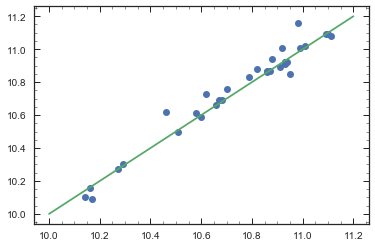

In [19]:
plt.plot(n_lmass,galDB.lmass,'o')
plt.plot([10,11.2],[10,11.2])

In [24]:
galDB['rf_lmass'] = n_lmass

In [25]:
# galDB.to_pickle('../data/sgal_param_DB.pkl')

In [23]:
n_lmass

[10.789999999999999,
 10.93,
 10.140000000000001,
 10.98,
 10.619999999999999,
 10.27,
 10.58,
 10.880000000000001,
 10.91,
 10.859999999999999,
 10.82,
 11.1,
 11.09,
 10.869999999999999,
 10.67,
 10.93,
 10.460000000000001,
 10.66,
 10.6,
 10.99,
 10.699999999999999,
 10.94,
 11.109999999999999,
 10.93,
 10.289999999999999,
 10.68,
 11.01,
 10.51,
 10.859999999999999,
 10.949999999999999,
 10.16,
 10.17,
 10.92]